In [2]:
%pip install matplotlib scikit-learn pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("sales_data_sample.csv")

In [5]:
# Hitung SALES
df["SALES"] = df["QUANTITYORDERED"] * df["PRICEEACH"]

# Ambil sub kolom untuk clustering
clustering_data = df[["QUANTITYORDERED", "PRICEEACH", "SALES", "PRODUCTLINE", "CITY"]].copy()

In [6]:
# CEK NILAI KOSONG
print("Jumlah missing value:")
print(clustering_data.isnull().sum())

# Drop baris dengan nilai kosong
clustering_data = clustering_data.dropna()

# Drop duplikat data
clustering_data = clustering_data.drop_duplicates()

# CEK TIPE DATA
print("Tipe data:")
print(clustering_data.dtypes)

clustering_data.info()

Jumlah missing value:
QUANTITYORDERED    0
PRICEEACH          0
SALES              0
PRODUCTLINE        0
CITY               0
dtype: int64
Tipe data:
QUANTITYORDERED      int64
PRICEEACH          float64
SALES              float64
PRODUCTLINE         object
CITY                object
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 2652 entries, 0 to 2823
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   QUANTITYORDERED  2652 non-null   int64  
 1   PRICEEACH        2652 non-null   float64
 2   SALES            2652 non-null   float64
 3   PRODUCTLINE      2652 non-null   object 
 4   CITY             2652 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 124.3+ KB


In [7]:
clustering_data.head()

,QUANTITYORDERED,PRICEEACH,SALES,PRODUCTLINE,CITY
0,30,100.00,3000.00,Vintage Cars,Nashua
1,50,67.80,3390.00,Vintage Cars,Nashua
2,22,86.51,1903.22,Vintage Cars,Nashua
3,49,34.47,1689.03,Vintage Cars,Nashua
4,25,100.00,2500.00,Vintage Cars,Frankfurt


In [8]:
# Tangani outlier dengan z-score
from scipy.stats import zscore
numeric_cols = clustering_data.select_dtypes(include=["float64", "int64"]).columns
z_scores = zscore(clustering_data[numeric_cols])
clustering_data = clustering_data[(abs(z_scores) < 3).all(axis=1)]

In [9]:
# Encode kolom kategorikal
from sklearn.preprocessing import LabelEncoder

# Simpan encoder-nya ke variabel
le_productline = LabelEncoder()
le_city = LabelEncoder()

clustering_data["PRODUCTLINE"] = le_productline.fit_transform(clustering_data["PRODUCTLINE"])
clustering_data["CITY"] = le_city.fit_transform(clustering_data["CITY"])

In [10]:
# Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_data)

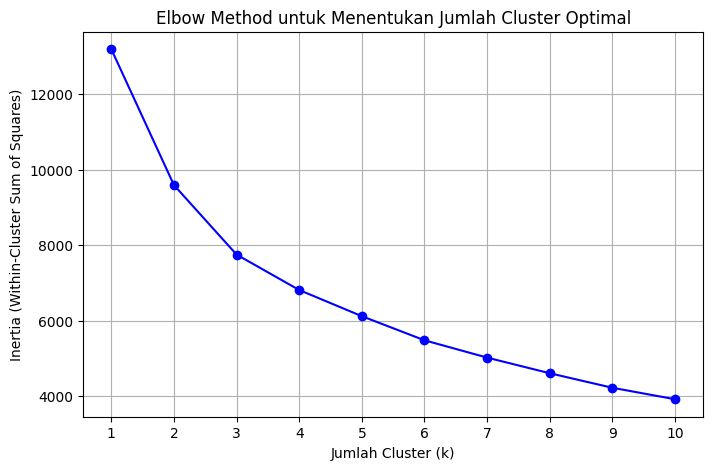

In [11]:
# Elbow method untuk menentukan jumlah cluster optimal
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster Optimal')
plt.xticks(K)
plt.grid(True)
plt.show()

In [20]:
# Berdasarkan plot Elbow Method pada cell sebelumnya, jumlah cluster optimal biasanya dipilih pada titik "elbow" (siku) grafik inertia.
# Dari nilai inertia yang ada di variabel 'inertia', kita bisa menampilkan nilainya untuk membantu analisis.

for k_val, inertia_val in zip(K, inertia):
    print(f"Cluster: {k_val}, Inertia: {inertia_val}")

print("\nPilih jumlah cluster pada titik di mana penurunan inertia mulai melambat (elbow).")
print("Dari visualisasi sebelumnya, kemungkinan optimal adalah 3 cluster (K=3).")

Cluster: 1, Inertia: 13190.000000000005
Cluster: 2, Inertia: 9590.993381249988
Cluster: 3, Inertia: 7751.267996105934
Cluster: 4, Inertia: 6812.792825801813
Cluster: 5, Inertia: 6120.001921638373
Cluster: 6, Inertia: 5481.759595523231
Cluster: 7, Inertia: 5023.194241044099
Cluster: 8, Inertia: 4608.9442072312095
Cluster: 9, Inertia: 4224.634482027707
Cluster: 10, Inertia: 3920.892743568165

Pilih jumlah cluster pada titik di mana penurunan inertia mulai melambat (elbow).
Dari visualisasi sebelumnya, kemungkinan optimal adalah 3 cluster (K=3).


In [12]:
# KMeans clustering (3 cluster)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
labels = kmeans.fit_predict(X_scaled)

# Tambahkan hasil cluster ke data
clustering_data["Cluster"] = clusters

# Dataset + Cluster
clustering_data.head()

,QUANTITYORDERED,PRICEEACH,SALES,PRODUCTLINE,CITY,Cluster
0,30,100.00,3000.00,6,44,1
1,50,67.80,3390.00,6,44,2
2,22,86.51,1903.22,6,44,1
3,49,34.47,1689.03,6,44,0
4,25,100.00,2500.00,6,19,1


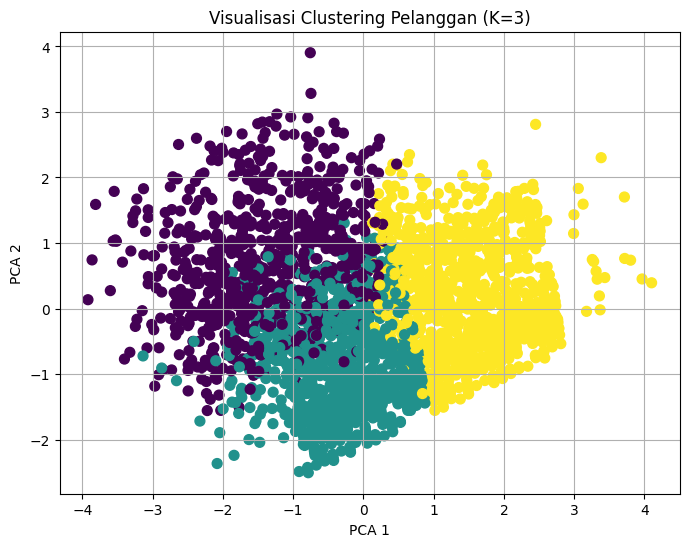

In [13]:
# Reduksi dimensi dengan PCA (untuk visualisasi 2D)
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap="viridis", s=50)
plt.title("Visualisasi Clustering Pelanggan (K=3)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [14]:
clustering_data["Cluster"] = labels

# Lihat statistik dari tiap cluster
cluster_summary = clustering_data.groupby("Cluster").agg({
    "QUANTITYORDERED": ["mean", "min", "max"],
    "PRICEEACH": ["mean", "min", "max"],
    "SALES": ["mean", "min", "max"],
    "PRODUCTLINE": pd.Series.mode,  # nilai paling sering = modus = mode
    "CITY": pd.Series.mode
})

print(cluster_summary)

        QUANTITYORDERED          PRICEEACH                       SALES  \
                   mean min max       mean    min     max         mean   
Cluster                                                                  
0             33.868938  11  64  54.951337  26.88   77.73  1847.509069   
1             26.986066   6  38  94.383044  67.97  100.00  2545.821018   
2             43.558386  35  64  93.155361  52.66  100.00  4044.344384   

                          PRODUCTLINE CITY  
             min      max        mode mode  
Cluster                                     
0         482.13  3064.32           6   34  
1         541.14  3400.00           0   34  
2        2807.22  6100.00           0   34  


In [15]:
# Liat kota sama product line
print("Label 0 PRODUCTLINE:", le_productline.inverse_transform([0])[0])
print("Label 6 PRODUCTLINE:", le_productline.inverse_transform([6])[0])
print("Label 34 CITY:", le_city.inverse_transform([34])[0])

Label 0 PRODUCTLINE: Classic Cars
Label 6 PRODUCTLINE: Vintage Cars
Label 34 CITY: Madrid


In [16]:
le_productline.classes_

array(['Classic Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains',
       'Trucks and Buses', 'Vintage Cars'], dtype=object)

In [17]:
le_city.classes_

array(['Aaarhus', 'Allentown', 'Barcelona', 'Bergamo', 'Bergen', 'Boras',
       'Boston', 'Brickhaven', 'Bridgewater', 'Brisbane', 'Bruxelles',
       'Burbank', 'Burlingame', 'Cambridge', 'Charleroi', 'Chatswood',
       'Cowes', 'Dublin', 'Espoo', 'Frankfurt', 'Gensve', 'Glen Waverly',
       'Glendale', 'Graz', 'Helsinki', 'Kobenhavn', 'Koln', 'Las Vegas',
       'Lille', 'Liverpool', 'London', 'Los Angeles', 'Lule', 'Lyon',
       'Madrid', 'Makati City', 'Manchester', 'Marseille', 'Melbourne',
       'Minato-ku', 'Montreal', 'Munich', 'NYC', 'Nantes', 'Nashua',
       'New Bedford', 'New Haven', 'Newark', 'North Sydney', 'Osaka',
       'Oslo', 'Oulu', 'Paris', 'Pasadena', 'Philadelphia',
       'Reggio Emilia', 'Reims', 'Salzburg', 'San Diego', 'San Francisco',
       'San Jose', 'San Rafael', 'Sevilla', 'Singapore', 'South Brisbane',
       'Stavern', 'Strasbourg', 'Torino', 'Toulouse', 'Tsawassen',
       'Vancouver', 'Versailles', 'White Plains'], dtype=object)

In [18]:
le_city = LabelEncoder()
le_city.fit(df["CITY"])
city_mapping = dict(zip(le_city.transform(le_city.classes_), le_city.classes_))

print("\nCITY Mapping:")
for k, v in city_mapping.items():
    print(f"{k}: {v}")


CITY Mapping:
0: Aaarhus
1: Allentown
2: Barcelona
3: Bergamo
4: Bergen
5: Boras
6: Boston
7: Brickhaven
8: Bridgewater
9: Brisbane
10: Bruxelles
11: Burbank
12: Burlingame
13: Cambridge
14: Charleroi
15: Chatswood
16: Cowes
17: Dublin
18: Espoo
19: Frankfurt
20: Gensve
21: Glen Waverly
22: Glendale
23: Graz
24: Helsinki
25: Kobenhavn
26: Koln
27: Las Vegas
28: Lille
29: Liverpool
30: London
31: Los Angeles
32: Lule
33: Lyon
34: Madrid
35: Makati City
36: Manchester
37: Marseille
38: Melbourne
39: Minato-ku
40: Montreal
41: Munich
42: NYC
43: Nantes
44: Nashua
45: New Bedford
46: New Haven
47: Newark
48: North Sydney
49: Osaka
50: Oslo
51: Oulu
52: Paris
53: Pasadena
54: Philadelphia
55: Reggio Emilia
56: Reims
57: Salzburg
58: San Diego
59: San Francisco
60: San Jose
61: San Rafael
62: Sevilla
63: Singapore
64: South Brisbane
65: Stavern
66: Strasbourg
67: Torino
68: Toulouse
69: Tsawassen
70: Vancouver
71: Versailles
72: White Plains


In [19]:
le_productline = LabelEncoder()
le_productline.fit(df["PRODUCTLINE"])
productline_mapping = dict(zip(le_productline.transform(le_productline.classes_), le_productline.classes_))

print("\nProductLine Mapping:")
for k, v in productline_mapping.items():
    print(f"{k}: {v}")


ProductLine Mapping:
0: Classic Cars
1: Motorcycles
2: Planes
3: Ships
4: Trains
5: Trucks and Buses
6: Vintage Cars
